In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('datasets/train_feature_engineer.csv')

In [3]:
#create X and y values
X = data.drop('SalePrice',axis=1)
y = data['SalePrice']

#log y values
y = np.log(y)

In [4]:
#repeat previous steps
#create poly features, train test split then scale
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
poly_convert = PolynomialFeatures(include_bias=False)
X_poly = poly_convert.fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size=0.3)

In [6]:
#use grid search and elastic net to find a good model

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
#create pipeline

In [9]:
pipe = Pipeline([('ss',StandardScaler()),('en',ElasticNet())])

In [10]:
#check available parameters
pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('en', ElasticNet())],
 'verbose': False,
 'ss': StandardScaler(),
 'en': ElasticNet(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'en__alpha': 1.0,
 'en__copy_X': True,
 'en__fit_intercept': True,
 'en__l1_ratio': 0.5,
 'en__max_iter': 1000,
 'en__normalize': False,
 'en__positive': False,
 'en__precompute': False,
 'en__random_state': None,
 'en__selection': 'cyclic',
 'en__tol': 0.0001,
 'en__warm_start': False}

In [11]:
pipe_params = {'en__l1_ratio':[.1, .7, 1],
              'en__selection':['random'], #random so it will run faster
              'en__warm_start':[True], #warm start to run faster
              'en__alpha':np.logspace(-6, 6, 5),
              'en__max_iter': [10000000]}

In [12]:
model = GridSearchCV(pipe,pipe_params,cv=5,verbose=1,scoring='neg_mean_squared_error')
#set scoring to neg mean squared error as this is what we are trying to minimize

In [13]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  4.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('en', ElasticNet())]),
             param_grid={'en__alpha': array([1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06]),
                         'en__l1_ratio': [0.1, 0.7, 1],
                         'en__max_iter': [10000000],
                         'en__selection': ['random'],
                         'en__warm_start': [True]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
model.best_params_

{'en__alpha': 0.001,
 'en__l1_ratio': 1,
 'en__max_iter': 10000000,
 'en__selection': 'random',
 'en__warm_start': True}

In [15]:
#save model for future use - in case
from joblib import dump,load

In [16]:
dump(model,'models/gs_tune1.joblib')

['models/gs_tune1.joblib']

In [17]:
#model.best_params_
#{'en__alpha': 1.0,
# 'en__l1_ratio': 0.1,
# 'en__max_iter': 10000000,
# 'en__selection': 'random',
# 'en__warm_start': True}

In [18]:
#Get predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
predictions = model.predict(X_poly)

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
#RSME score: train set
np.sqrt(mean_squared_error(np.exp(y_train),np.exp(train_predictions)))

10749.685297079479

Text(0.5, 1.0, 'Predictions vs Actual y - TRAIN SET')

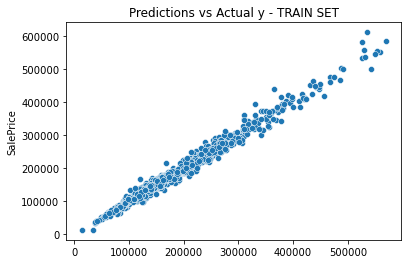

In [21]:
#plot train predictions vs actual y train
sns.scatterplot(x=np.exp(train_predictions),y=np.exp(y_train))
plt.title('Predictions vs Actual y - TRAIN SET')

In [22]:
#RSME score: test set
np.sqrt(mean_squared_error(np.exp(y_test),np.exp(test_predictions)))

24160.077822605403

Text(0.5, 1.0, 'Predictions vs Actual y - TEST SET')

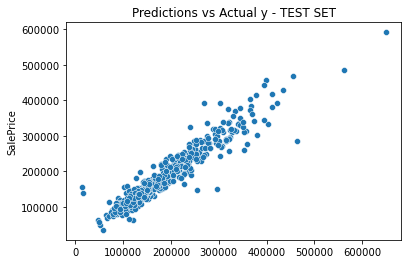

In [23]:
#plot train predictions vs actual y train
sns.scatterplot(x=np.exp(test_predictions),y=np.exp(y_test))
plt.title('Predictions vs Actual y - TEST SET')

In [24]:
#RSME score: whole set
np.sqrt(mean_squared_error(np.exp(y),np.exp(predictions)))

16005.049244015341

Text(0.5, 1.0, 'Predictions vs Actual y')

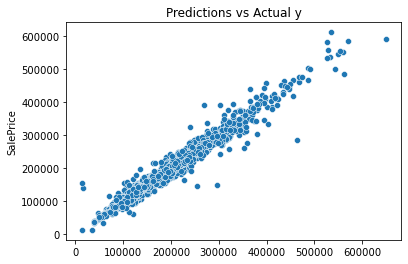

In [25]:
#plot predictions vs actual y
sns.scatterplot(x=np.exp(predictions),y=np.exp(y))
plt.title('Predictions vs Actual y')

In [26]:
#RSME TRAIN: 10,749
#RSME TEST: 24,160
#RSME WHOLE DATA: 16,005

#RSME = Root mean square error
#Roughly how much the predicted price differs from the actual sale price
#RSME also punishes large differences (outliers)

#from the RSME, there looks like there might be some overfitting to the train portion of the data

In [30]:
#run another grid search

#run another grid search to try to find if there are better hyperparameters around the area
pipe_params = {'en__l1_ratio':[.7, .9, .99, 1],
              'en__selection':['random'], #random so it will run faster
              'en__warm_start':[True], #warm start to run faster
              'en__alpha':[0.01,0.1,1],
              'en__max_iter': [10000000]}

In [31]:
model2 = GridSearchCV(pipe,pipe_params,cv=5,verbose=1,scoring='neg_mean_squared_error')

In [32]:
#train test split at a different random state
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size=0.3,random_state=59)

In [33]:
model2.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('en', ElasticNet())]),
             param_grid={'en__alpha': [0.01, 0.1, 1],
                         'en__l1_ratio': [0.7, 0.9, 0.99, 1],
                         'en__max_iter': [10000000],
                         'en__selection': ['random'],
                         'en__warm_start': [True]},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
model2.best_params_

{'en__alpha': 0.01,
 'en__l1_ratio': 1,
 'en__max_iter': 10000000,
 'en__selection': 'random',
 'en__warm_start': True}

In [35]:
dump(model,'models/gs_tune2.joblib') #save model

['models/gs_tune2.joblib']

In [36]:
#Get predictions
train_predictions = model2.predict(X_train)
test_predictions = model2.predict(X_test)
predictions = model2.predict(X_poly)

In [37]:
#RSME score: train set
np.sqrt(mean_squared_error(np.exp(y_train),np.exp(train_predictions)))

20445.460372944763

Text(0.5, 1.0, 'Predictions vs Actual y - TRAIN SET')

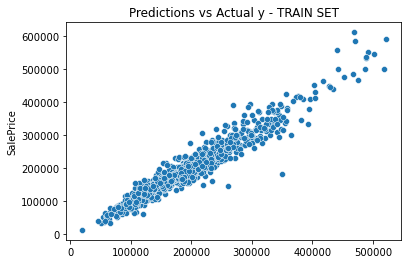

In [38]:
#plot train predictions vs actual y train
sns.scatterplot(x=np.exp(train_predictions),y=np.exp(y_train))
plt.title('Predictions vs Actual y - TRAIN SET')

In [39]:
#RSME score: test set
np.sqrt(mean_squared_error(np.exp(y_test),np.exp(test_predictions)))

22025.771735377486

Text(0.5, 1.0, 'Predictions vs Actual y - TEST SET')

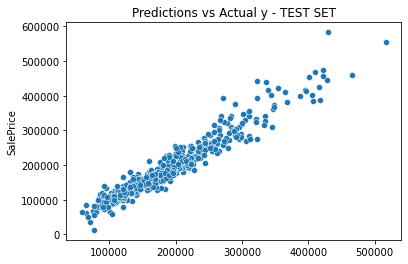

In [40]:
#plot train predictions vs actual y train
sns.scatterplot(x=np.exp(test_predictions),y=np.exp(y_test))
plt.title('Predictions vs Actual y - TEST SET')

In [41]:
#RSME score: whole set
np.sqrt(mean_squared_error(np.exp(y),np.exp(predictions)))

20932.632136303662

Text(0.5, 1.0, 'Predictions vs Actual y')

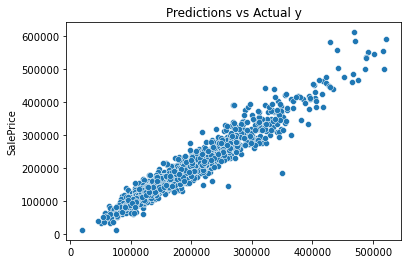

In [42]:
#plot predictions vs actual y
sns.scatterplot(x=np.exp(predictions),y=np.exp(y))
plt.title('Predictions vs Actual y')

In [43]:
#RSME TRAIN: 20,445
#RSME TEST: 22,025
#RSME WHOLE DATA: 20,932

#RSME for this GridSearch looks better
#no overfitting
#RSME for both sets looks about the same

In [46]:
#best hyperparameters found:
#{'en__alpha': 0.01,
# 'en__l1_ratio': 0.7,
# 'en__max_iter': 10000000,
# 'en__selection': 'random',
# 'en__warm_start': True}

In [47]:
#will use these parameters to create another model using the whole train dataset
#use this final model to predict price in final test dataset